In [1]:
#okay i am very far behind
# RESERVE THIS CELL FOR DATASET CREATION
import numpy as np
import pandas as pd

#efficiency is not so much of an issue due to the availability of computational power.
#Using info about the sieve of eratosthenes algorithm from https://www.geeksforgeeks.org/sieve-of-eratosthenes/
def sieved_list(limit): # I may need to remove 2 from this list. See notes in Jansen's paper.
    pool = list(range(3,limit+1))
    for i in pool:
        for j in pool:
            if i != j:
                if j%i == 0:
                    pool.remove(j)
    return pool
def semiprimes_from(primes_list):
    semiprime = []
    smallest_prime = []
    for i in primes_list:
        for j in primes_list:
            if i!=j:
                semiprime.append(i*j)
                if i<j:
                    smallest_prime.append(i)
                else:
                    smallest_prime.append(j)
        primes.remove(i)
    return semiprime, smallest_prime

def make_bin(number,size):
    bits = {}
    number = number.replace("0b","")
    number = number.zfill(size)
    index = 0
    for b in number:
        bits["B{}".format(index)] = b
        index+=1
    return bits


primes = sieved_list(1000) # this thus creates our massive list of primes. The semiprimes involve the products of said primes
# print(primes)
semiprimes, smallest_p = semiprimes_from(primes)


SEMIPRIME_SIZE = 20
PRIME_SIZE = 10

bin_semiprimes = []
for i in semiprimes:
    temp = make_bin(bin(i),SEMIPRIME_SIZE)
    bin_semiprimes.append(temp)

bin_smallest_p = []
for i in smallest_p:
    temp2 = make_bin(bin(i),PRIME_SIZE)
    bin_smallest_p.append(temp2)

In [2]:
#making dataframes
df_to_hundmill = pd.DataFrame(bin_semiprimes).astype('int8')

df_to_mill = df_to_hundmill.iloc[:10542].astype('int8')
df_to_thou = df_to_mill.iloc[:4984].astype('int8')
df_to_tenthou = df_to_mill.iloc[:10460].astype('int8')
df_to_hundthou = df_to_mill.iloc[:10470].astype('int8')

In [3]:
#now for our label data
df_to_hundmill_label = pd.DataFrame(bin_smallest_p).astype('int8')
df_to_mill_label = df_to_hundmill_label.iloc[:10542].astype('int8')
df_to_thou_label = df_to_mill_label.iloc[:4984].astype('int8')
df_to_tenthou_label = df_to_mill_label.iloc[:10460].astype('int8')
df_to_hundthou_label = df_to_mill_label.iloc[:10470].astype('int8')

the label and semiprime dataframes run in parallel with corresponding indexes. Merging them would be painful because their column headers are the same.

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)




#The following model is based on the Murat paper.

model = tf.keras.Sequential(
        layers = [
            tf.keras.layers.LSTM(128,name="lstm_1",return_sequences=True,input_shape=(1,SEMIPRIME_SIZE)),
            tf.keras.layers.BatchNormalization(name = "normalisation_1"),
            tf.keras.layers.Dropout(0.3,name="dropout_1"),
            tf.keras.layers.LSTM(256,name="lstm_2",return_sequences=True),
            tf.keras.layers.BatchNormalization(name = "normalisation_2"),
            tf.keras.layers.Dropout(0.3,name="dropout_2"),
            tf.keras.layers.LSTM(512,name="lstm_3",return_sequences=False),
            tf.keras.layers.BatchNormalization(name = "normalisation_3"),
            tf.keras.layers.Dropout(0.3,name="dropout_3"),
            tf.keras.layers.Dense(128,name="dense_1",activation="relu"),
            tf.keras.layers.BatchNormalization(name = "normalisation_4"),
            tf.keras.layers.Dropout(0.3,name="dropout_4"),
            tf.keras.layers.Dense(100,name="dense_2",activation="relu"),
            tf.keras.layers.BatchNormalization(name = "normalisation_5"),
            tf.keras.layers.Dropout(0.4,name="dropout_5"),
            tf.keras.layers.Dense(PRIME_SIZE,activation="sigmoid",name="out")
        ])
ones = tf.ones([1,1,SEMIPRIME_SIZE]) #Why is that 20? The largest semiprime that is dealt with is a 20 bit long number. Hence why the third dimension is 20.
#Batch size 1, time steps 20, features 1
# print(ones)
y = model(ones)
# print(y)
model.compile(
    optimizer=keras.optimizers.RMSprop(),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.AUC()],
)
model.summary()

2.9.1
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 1, 128)            76288     
                                                                 
 normalisation_1 (BatchNorma  (None, 1, 128)           512       
 lization)                                                       
                                                                 
 dropout_1 (Dropout)         (None, 1, 128)            0         
                                                                 
 lstm_2 (LSTM)               (None, 1, 256)            394240    
                                                                 
 normalisation_2 (BatchNorma  (None, 1, 256)           1024      
 lization)                                                       
                                                                 
 dropout_2 (Dropout)         (None, 1, 256)     

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
#Quick function to speedily do all the necessary prep
def dataprep(data,data_labels,testsize):
    reshape = data.to_numpy().reshape(data.shape[0],1,SEMIPRIME_SIZE)
    reshape_labels = data_labels.to_numpy().reshape(data.shape[0],PRIME_SIZE)
    return train_test_split(reshape,reshape_labels,test_size=testsize,random_state=42)

In [29]:
#Train-test split as specified in the paper.

Batch_size=4 #after some quick trials, bs = 2 seems to work best.
# print(df_to_mill_label.shape)
train_thm, test_thm, train_thm_label,test_thm_label = dataprep(df_to_hundmill,df_to_hundmill_label,0.9)
train_tm, test_tm, train_tm_label,test_tm_label = dataprep(df_to_mill,df_to_mill_label,0.9) # This train test split does rather heavily sway the numbers. Keeping the training set low avoids performance issues.
train_tt, test_tt, train_tt_label,test_tt_label = dataprep(df_to_thou,df_to_thou_label,0.33)
train_ttt, test_ttt, train_ttt_label,test_ttt_label = dataprep(df_to_tenthou,df_to_tenthou_label,0.33)
train_tht, test_tht, train_tht_label,test_tht_label = dataprep(df_to_hundthou,df_to_hundthou_label,0.33)




In [30]:
#now to fit the thing itself.
EPOCHS = 120
with tf.device('/GPU:0'):
    history = model.fit(train_ttt,train_ttt_label,epochs=EPOCHS,batch_size=Batch_size,validation_data=(test_ttt,test_ttt_label))

Epoch 1/120
1752/1752 [==============================] - 50s 27ms/step - loss: 0.5727 - auc_1: 0.7214 - val_loss: 0.7051 - val_auc_1: 0.7292
Epoch 2/120
1752/1752 [==============================] - 49s 28ms/step - loss: 0.5690 - auc_1: 0.7205 - val_loss: 0.6012 - val_auc_1: 0.7324
Epoch 3/120
1752/1752 [==============================] - 49s 28ms/step - loss: 0.5660 - auc_1: 0.7241 - val_loss: 0.6133 - val_auc_1: 0.7392
Epoch 4/120
1752/1752 [==============================] - 49s 28ms/step - loss: 0.5653 - auc_1: 0.7255 - val_loss: 0.5479 - val_auc_1: 0.7500
Epoch 5/120
1752/1752 [==============================] - 49s 28ms/step - loss: 0.5629 - auc_1: 0.7280 - val_loss: 0.5579 - val_auc_1: 0.7522
Epoch 6/120
1752/1752 [==============================] - 50s 28ms/step - loss: 0.5614 - auc_1: 0.7286 - val_loss: 0.5646 - val_auc_1: 0.7519
Epoch 7/120
1752/1752 [==============================] - 49s 28ms/step - loss: 0.5621 - auc_1: 0.7268 - val_loss: 0.5768 - val_auc_1: 0.7545
Epoch 8/120
1

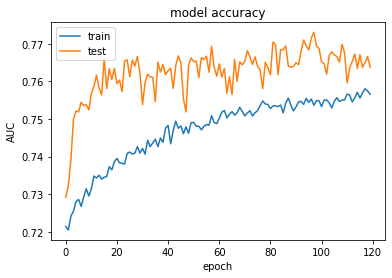

In [31]:
#Visualisation
import matplotlib.pyplot as plt
#ctrl c ctrl v time
plt.plot(history.history['auc_1'])
plt.plot(history.history['val_auc_1'])
plt.title('model accuracy')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

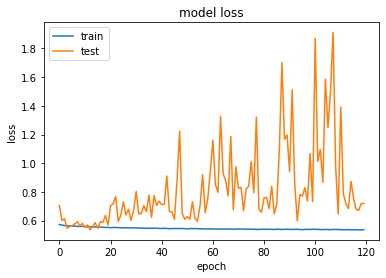

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [33]:
#Now that the figures are generated, we can move on to our tables.
#The way I see it, we can make the generated models predict values, then calculate their accuracy based on their predictions
#We can subtract each digit of the prediction from the label, then take abs(), then take the sum, giving the total errors.

def bit_accuracy(data,label,predictor):
    bit_acc = {}
    for i in range(0,PRIME_SIZE+1):
        bit_acc[i] = 0
    for n in range(data.shape[0]):
        pred = np.round(predictor.predict(data[n:n+1],verbose=0))
        values = []
        for i in range(PRIME_SIZE):
            bit_hat = pred[0][i]
            bit_label = label[n:n+1][0][i]
            diff = bit_label-bit_hat
            values.append(diff)
        arr = np.array(values)
        faults = np.sum(np.absolute(arr))
        bit_acc[faults] += 1
    for i in bit_acc:
        bit_acc[i] = round(bit_acc[i]/data.shape[0],2)
    return bit_acc

ba_train = bit_accuracy(train_tt,train_tt_label,model)
ba_test = bit_accuracy(test_tt,test_tt_label,model)
print(ba_train)
print(ba_test)


{0: 0.01, 1: 0.1, 2: 0.21, 3: 0.29, 4: 0.21, 5: 0.09, 6: 0.07, 7: 0.02, 8: 0.0, 9: 0.0, 10: 0.0}
{0: 0.02, 1: 0.1, 2: 0.2, 3: 0.27, 4: 0.21, 5: 0.1, 6: 0.06, 7: 0.03, 8: 0.0, 9: 0.0, 10: 0.0}


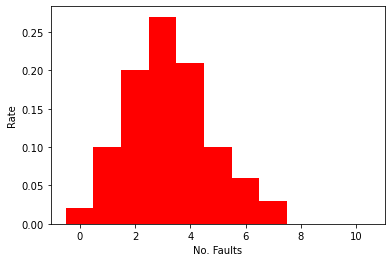

In [34]:
plt.bar(ba_test.keys(), ba_test.values(), 1, color='r')
plt.ylabel('Rate')
plt.xlabel('No. Faults')
plt.show()

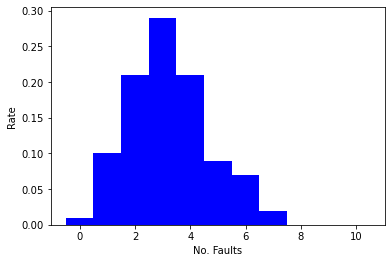

In [35]:
plt.bar(ba_train.keys(), ba_train.values(), 1, color='b')
plt.ylabel('Rate')
plt.xlabel('No. Faults')
plt.show()

In [36]:
print(ba_train)
print(ba_test)

{0: 0.01, 1: 0.1, 2: 0.21, 3: 0.29, 4: 0.21, 5: 0.09, 6: 0.07, 7: 0.02, 8: 0.0, 9: 0.0, 10: 0.0}
{0: 0.02, 1: 0.1, 2: 0.2, 3: 0.27, 4: 0.21, 5: 0.1, 6: 0.06, 7: 0.03, 8: 0.0, 9: 0.0, 10: 0.0}


In [37]:
#basically just make everything else in queue to run so i have everything when needed
model = tf.keras.Sequential(
        layers = [
            tf.keras.layers.LSTM(128,name="lstm_1",return_sequences=True,input_shape=(1,SEMIPRIME_SIZE)),
            tf.keras.layers.BatchNormalization(name = "normalisation_1"),
            tf.keras.layers.Dropout(0.3,name="dropout_1"),
            tf.keras.layers.LSTM(256,name="lstm_2",return_sequences=True),
            tf.keras.layers.BatchNormalization(name = "normalisation_2"),
            tf.keras.layers.Dropout(0.3,name="dropout_2"),
            tf.keras.layers.LSTM(512,name="lstm_3",return_sequences=False),
            tf.keras.layers.BatchNormalization(name = "normalisation_3"),
            tf.keras.layers.Dropout(0.3,name="dropout_3"),
            tf.keras.layers.Dense(128,name="dense_1",activation="relu"),
            tf.keras.layers.BatchNormalization(name = "normalisation_4"),
            tf.keras.layers.Dropout(0.3,name="dropout_4"),
            tf.keras.layers.Dense(100,name="dense_2",activation="relu"),
            tf.keras.layers.BatchNormalization(name = "normalisation_5"),
            tf.keras.layers.Dropout(0.4,name="dropout_5"),
            tf.keras.layers.Dense(PRIME_SIZE,activation="sigmoid",name="out")
        ])
ones = tf.ones([1,1,SEMIPRIME_SIZE]) #Why is that 20? The largest semiprime that is dealt with is a 20 bit long number. Hence why the third dimension is 20.
#Batch size 1, time steps 20, features 1
# print(ones)
y = model(ones)
# print(y)
model.compile(
    optimizer=keras.optimizers.RMSprop(),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.AUC()],
)

In [ ]:
with tf.device('/GPU:0'):
    history = model.fit(train_tht,train_tht_label,epochs=EPOCHS,batch_size=Batch_size,validation_data=(test_tht,test_tht_label))

Epoch 1/120
1754/1754 [==============================] - 47s 24ms/step - loss: 0.6736 - auc_2: 0.6604 - val_loss: 0.5413 - val_auc_2: 0.7449
Epoch 2/120
1754/1754 [==============================] - 42s 24ms/step - loss: 0.5730 - auc_2: 0.7179 - val_loss: 0.5249 - val_auc_2: 0.7567
Epoch 3/120
1754/1754 [==============================] - 42s 24ms/step - loss: 0.5595 - auc_2: 0.7298 - val_loss: 0.5177 - val_auc_2: 0.7652
Epoch 4/120
 964/1754 [===============>..............] - ETA: 17s - loss: 0.5588 - auc_2: 0.7304

In [ ]:
ba_train = bit_accuracy(train_tht,train_tht_label,model)
ba_test = bit_accuracy(test_tht,test_tht_label,model)
plt.bar(ba_test.keys(), ba_test.values(), 1, color='r')
plt.ylabel('Rate')
plt.xlabel('No. Faults')
plt.show()

In [ ]:
plt.bar(ba_train.keys(), ba_train.values(), 1, color='b')
plt.ylabel('Rate')
plt.xlabel('No. Faults')
plt.show()

In [ ]:
print(ba_train)
print(ba_test)

In [ ]:
#basically just make everything else in queue to run so i have everything when needed
model = tf.keras.Sequential(
        layers = [
            tf.keras.layers.LSTM(128,name="lstm_1",return_sequences=True,input_shape=(1,SEMIPRIME_SIZE)),
            tf.keras.layers.BatchNormalization(name = "normalisation_1"),
            tf.keras.layers.Dropout(0.3,name="dropout_1"),
            tf.keras.layers.LSTM(256,name="lstm_2",return_sequences=True),
            tf.keras.layers.BatchNormalization(name = "normalisation_2"),
            tf.keras.layers.Dropout(0.3,name="dropout_2"),
            tf.keras.layers.LSTM(512,name="lstm_3",return_sequences=False),
            tf.keras.layers.BatchNormalization(name = "normalisation_3"),
            tf.keras.layers.Dropout(0.3,name="dropout_3"),
            tf.keras.layers.Dense(128,name="dense_1",activation="relu"),
            tf.keras.layers.BatchNormalization(name = "normalisation_4"),
            tf.keras.layers.Dropout(0.3,name="dropout_4"),
            tf.keras.layers.Dense(100,name="dense_2",activation="relu"),
            tf.keras.layers.BatchNormalization(name = "normalisation_5"),
            tf.keras.layers.Dropout(0.4,name="dropout_5"),
            tf.keras.layers.Dense(PRIME_SIZE,activation="sigmoid",name="out")
        ])
ones = tf.ones([1,1,SEMIPRIME_SIZE]) #Why is that 20? The largest semiprime that is dealt with is a 20 bit long number. Hence why the third dimension is 20.
#Batch size 1, time steps 20, features 1
# print(ones)
y = model(ones)
# print(y)
model.compile(
    optimizer=keras.optimizers.RMSprop(),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.AUC()],
)

In [ ]:
with tf.device('/GPU:0'):
    history = model.fit(train_tm,train_tm_label,epochs=EPOCHS,batch_size=Batch_size,validation_data=(test_tm,test_tm_label))

In [ ]:
ba_train = bit_accuracy(train_thm,train_tm_label,model)
ba_test = bit_accuracy(test_tm,test_tm_label,model)
plt.bar(ba_test.keys(), ba_test.values(), 1, color='r')
plt.ylabel('Rate')
plt.xlabel('No. Faults')
plt.show()

In [ ]:
plt.bar(ba_train.keys(), ba_train.values(), 1, color='b')
plt.ylabel('Rate')
plt.xlabel('No. Faults')
plt.show()

In [ ]:
print(ba_train)
print(ba_test)

In [12]:
#I want to see my data.
import seaborn as sns #some copy paste work from my own previous things
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter = 500,learning_rate=200)
tsne_results = tsne.fit_transform(df_to_hundmill.values)
print("TSNE completed.")

df = pd.DataFrame(
                 {
                     'tsne2d_one':tsne_results[:,0],
                     'tsne2d_two':tsne_results[:,1],
                     'smallest_p':smallest_p
                 }
)

C:\Users\desktop\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10542 samples in 0.001s...
[t-SNE] Computed neighbors for 10542 samples in 1.778s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10542
[t-SNE] Computed conditional probabilities for sample 2000 / 10542
[t-SNE] Computed conditional probabilities for sample 3000 / 10542
[t-SNE] Computed conditional probabilities for sample 4000 / 10542
[t-SNE] Computed conditional probabilities for sample 5000 / 10542
[t-SNE] Computed conditional probabilities for sample 6000 / 10542
[t-SNE] Computed conditional probabilities for sample 7000 / 10542
[t-SNE] Computed conditional probabilities for sample 8000 / 10542
[t-SNE] Computed conditional probabilities for sample 9000 / 10542
[t-SNE] Computed conditional probabilities for sample 10000 / 10542
[t-SNE] Computed conditional probabilities for sample 10542 / 10542
[t-SNE] Mean sigma: 0.743536
[t-SNE] KL divergence after 50 iterations with early exaggeration: 93.016068
[t-SNE] KL 

<AxesSubplot:xlabel='tsne2d_one', ylabel='tsne2d_two'>

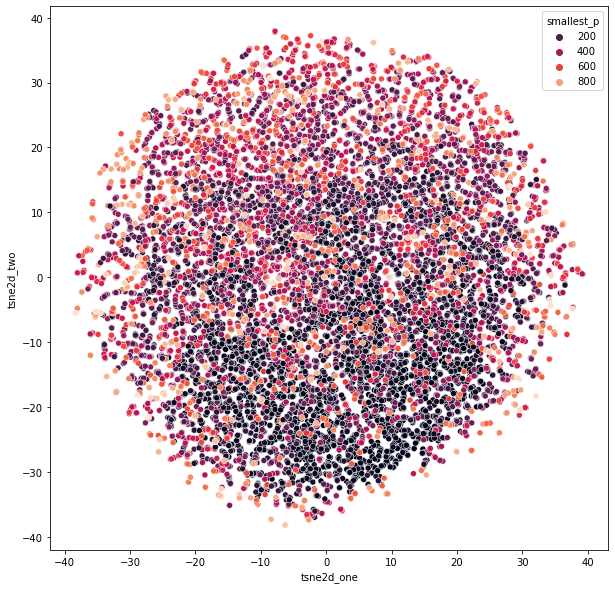

In [13]:
plt.figure(figsize=(10,10))
sns.scatterplot(
    x="tsne2d_one", y="tsne2d_two",
    palette=sns.color_palette("rocket", as_cmap=True),
    data=df,
    hue = 'smallest_p',
    alpha=1)

In [14]:
#More data stuff if possible.
pca = PCA(n_components = 'mle')
# print(feat_cols)
pc_fm = pca.fit_transform(df_to_mill.values)
print("Explained Variance:",pca.explained_variance_ratio_)

Explained Variance: [0.06785929 0.05868991 0.05837761 0.0574471  0.05718393 0.05667287
 0.05643327 0.05615098 0.05589111 0.05541571 0.05431684 0.05421397
 0.05366183 0.05316947 0.05118579 0.04915809 0.04518572 0.03713851
 0.02015631]


In [ ]:
# model_without_regularisation = tf.keras.Sequential(
#         layers = [
#             tf.keras.layers.LSTM(128,name="lstm_1",return_sequences=True,input_shape=(1,20)),
#             tf.keras.layers.LSTM(256,name="lstm_2",return_sequences=True),
#             tf.keras.layers.LSTM(512,name="lstm_3",return_sequences=False),
#             tf.keras.layers.Dense(128,name="dense_1",activation="relu"),
#             tf.keras.layers.Dense(100,name="dense_2",activation="relu"),
#             tf.keras.layers.Dense(10,activation="sigmoid",name="out")
#         ])
# ones = tf.ones([1,1,20])
# y = model_without_regularisation(ones)
# model_without_regularisation.compile(
#     optimizer=keras.optimizers.RMSprop(),
#     loss=keras.losses.BinaryCrossentropy(),
#     metrics=[tf.keras.metrics.AUC()],
#                                     )
# history2 = model_without_regularisation.fit(train_tm,train_tm_label,epochs=120,batch_size=Batch_size,validation_data=(test_tm,test_tm_label))


In [ ]:
# plt.plot(history2.history['auc_1'])
# plt.plot(history2.history['val_auc_1'])
# plt.title('model accuracy (without regularisation)')
# plt.ylabel('AUC')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()